# Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from pathlib import Path

%matplotlib inline

import matplotlib.dates as mdates

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.feature_extraction import DictVectorizer

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV


from xgboost import XGBRegressor
import xgboost as xgb

from lightgbm import LGBMRegressor
import lightgbm as lgb

# CSV Reads

In [19]:
data_airports = pd.read_csv(
    "/home/yokhr/projects/forecasting/data/master_data_KIX_AODB/AODB_airport_master.csv"
)

data_countries = pd.read_csv(
    "/home/yokhr/projects/forecasting/data/master_data_KIX_AODB/AODB_country_master.csv"
)

all_files = list(
    Path("/home/yokhr/projects/forecasting/data/KIX_AODB_data_planned").glob("*.csv")
)
data_planned = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

all_files = list(
    Path("/home/yokhr/projects/forecasting/data/KIX_AODB_data").glob("*.csv")
)
data_actual = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# filter out 17 January, it's today
mask = pd.to_datetime(data_actual["[Arr] SIBT"]).dt.floor("d") != pd.to_datetime(
    "2023-1-26"
).floor("d")
data_actual = data_actual[mask].copy()

 ## CSV read (for seat capacity)


In [20]:
data_seat_cap = pd.read_csv(
    "/home/yokhr/projects/forecasting/data/seat_capacity_master.csv"
)

data_seat_cap

,A/L,Aircraft type,Capacity,Remark
0,5J,A321,230,NaN
1,5J,A21N,236,NaN
2,5J,A339,459,NaN
3,5J,A333,230,NaN
4,7C,B738,174,NaN
...,...,...,...,...
106,VZ,A320,180,←暫定。要確認
107,XJ,A333,367,NaN
108,D7,A333,367,←暫定。要確認
109,ZG,B788,290,NaN


# Data cleaning & augmenting

In [21]:
def data_cleaning(data_actual, training: bool = True):
    # generate proper format
    mask = (
        (data_actual["[Dep] Flight Designator"].notna())
        & (~data_actual["[Arr] Status"].isin(["Not operating", "Cancelled"]))
        & (~data_actual["[Dep] Status"].isin(["Not operating", "Cancelled"]))
    )
    data_dep = pd.DataFrame.from_dict(
        {
            "L Board Pax": pd.to_numeric(
                data_actual[mask]["[Dep]  L Board Pax"], errors="coerce"
            ).to_list(),
            "Routing-FirstLeg": data_actual[mask]["[Dep] Routing"]
            .apply(lambda x: x[-4:])
            .to_list(),
            "Datetime": pd.to_datetime(data_actual[mask]["[Dep] SOBT"]).to_list(),
            "Service Type": data_actual[mask]["[Dep] Service Type"].to_list(),
            "Traffic Type": data_actual[mask]["[Dep] Traffic Type"].to_list(),
            "UniqueID": pd.to_datetime(data_actual[mask]["[Dep] SOBT"]).dt.strftime(
                "%Y/%m/%d"
            )
            + " "
            + data_actual[mask]["[Dep] Flight Designator"],
            "Capacity": pd.to_numeric(
                data_actual[mask]["[Dep] Capacity"], errors="coerce"
            ).to_list(),
            "Flight Designator": data_actual[mask]["[Dep] Flight Designator"],
            # yokhr to add AL+ACFT column
            "AL+ACFT": data_actual[mask]["[Dep] Flight Designator"].str[:2]
            + "+"
            + data_actual[mask]["Aircraft type"],
        }
    )
    data_dep["Direction"] = "departure"

    mask = data_actual["[Arr] Flight Designator"].notna()
    data_arr = pd.DataFrame.from_dict(
        {
            "L Board Pax": pd.to_numeric(
                data_actual[mask]["[Arr]  L Board Pax"], errors="coerce"
            ).to_list(),
            "Routing-FirstLeg": data_actual[mask]["[Arr] Routing"]
            .apply(lambda x: x[0:4])
            .to_list(),
            "Datetime": pd.to_datetime(data_actual[mask]["[Arr] SIBT"]).to_list(),
            "Service Type": data_actual[mask]["[Arr] Service Type"].to_list(),
            "Traffic Type": data_actual[mask]["[Arr] Traffic Type"].to_list(),
            "UniqueID": pd.to_datetime(data_actual[mask]["[Arr] SIBT"]).dt.strftime(
                "%Y/%m/%d"
            )
            + " "
            + data_actual[mask]["[Arr] Flight Designator"],
            "Capacity": pd.to_numeric(
                data_actual[mask]["[Arr] Capacity"], errors="coerce"
            ).to_list(),
            "Flight Designator": data_actual[mask]["[Arr] Flight Designator"],
            # yokhr to add AL+ACFT column
            "AL+ACFT": data_actual[mask]["[Arr] Flight Designator"].str[:2]
            + "+"
            + data_actual[mask]["Aircraft type"],
        }
    )
    data_arr["Direction"] = "arrival"

    data_concat = pd.concat([data_dep, data_arr]).reset_index(drop=True)
    data_concat.drop_duplicates(subset=["UniqueID"], inplace=True)
    data = data_concat.copy()

    # select only useful columns
    data = data[
        [
            "Service Type",  # string
            "Traffic Type",  # string
            "Capacity",  # to convert to int
            "L Board Pax",  # int already
            "Direction",  # string
            "Datetime",  # date to convert to int for year/month/date/hour
            "Routing-FirstLeg",  # string, should be country
            "UniqueID",
            "Flight Designator",
            # yokhr to add AL+ACFT
            "AL+ACFT",
        ]
    ].copy()

    # filter out rows with irrelevant values
    mask = data["Service Type"].isin(["C", "G", "J"])
    data = data[mask].copy()

    # change capacity to numerical
    data["Capacity"] = pd.to_numeric(data["Capacity"], errors="coerce")
    data["L Board Pax"] = pd.to_numeric(data["L Board Pax"], errors="coerce")

    # split date into year month day
    data["Datetime"] = pd.to_datetime(data["Datetime"])
    data["Year"] = data["Datetime"].apply(lambda x: x.year)
    data["Month"] = data["Datetime"].apply(lambda x: x.month)
    data["Day"] = data["Datetime"].apply(lambda x: x.day)
    data["Weekday"] = data["Datetime"].apply(lambda x: x.weekday())
    data["Hour"] = data["Datetime"].apply(lambda x: x.hour)
    data["LinearDate"] = (
        pd.to_datetime(data["Datetime"]) - pd.to_datetime("2022-06-01")
    ) / np.timedelta64(1, "D")

    # for training, take relevant flights and calculate LF
    if training:
        mask = data["L Board Pax"] > 10
        data = data[mask].copy()
        data["L Board Pax"] = data["L Board Pax"].astype("int")
        data["Load Factor"] = data["L Board Pax"] / data["Capacity"]
        # remove wrong and na values
        data = data[
            (data["Load Factor"] < 1)
            & (data["Load Factor"] > 0)
            & (data["Load Factor"].notna())
        ]
    else:
        data["L Board Pax"] = np.nan
        data["Load Factor"] = np.nan

    # change routing to Country name then to Country code
    repl = (
        data_airports[["ICAO", "Country"]].set_index("ICAO").T.to_dict(orient="records")
    )
    data["Country"] = data["Routing-FirstLeg"].map(*repl)
    repl_country = (
        data_countries[["Name", "ISO-3166-1 alpha-2"]]
        .set_index("Name")
        .T.to_dict(orient="records")
    )
    data["Country"] = data["Country"].map(*repl_country)

    # holidays
    data["HolidayJP"] = 0
    data["HolidayOrigin"] = 0

    dct_holiday = {
        country_code: holidays.country_holidays(country_code)
        for country_code in data["Country"].unique()
        if hasattr(holidays, country_code)
    }

    for index, row in data.iterrows():
        # domestic holiday
        if row["Datetime"] in dct_holiday["JP"]:
            data.loc[index, "HolidayJP"] = 1
        # overseas holiday
        if row["Country"] in dct_holiday.keys():
            if row["Datetime"] in dct_holiday[row["Country"]]:
                data.loc[index, "HolidayOrigin"] = 1

    # drop old columns
    data.drop(
        [
            # "L Board Pax",
            # "Capacity",
            "Routing-FirstLeg",
            # "Datetime",
        ],
        axis="columns",
        inplace=True,
    )

    # change types for categories
    data["Service Type"] = data["Service Type"].astype("category")
    data["Traffic Type"] = data["Traffic Type"].astype("category")
    data["Direction"] = data["Direction"].astype("category")
    data["Country"] = data["Country"].astype("category")

    data["Month"] = data["Month"].astype("category")
    data["Day"] = data["Day"].astype("category")
    data["Weekday"] = data["Weekday"].astype("category")
    data["Hour"] = data["Hour"].astype("category")

    return data

### yokhr to set Seat Capacity from AL + ACFT sheet by Asai-san

In [36]:
data_seat_cap["AL+ACFT"] = data_seat_cap["A/L"] + "+" + data_seat_cap["Aircraft type"]
master_capacity1 = data_seat_cap[["AL+ACFT", "Capacity"]]

data_forecast_clean = (
    data_cleaning(data_planned, training=False)
    .drop("Capacity", axis=1)
    .join(master_capacity1.set_index("AL+ACFT"), on="AL+ACFT")
)
data_actual_clean = (
    data_cleaning(data_actual)
    .drop("Capacity", axis=1)
    .join(master_capacity1.set_index("AL+ACFT"), on="AL+ACFT")
)
# cap0 = data_forecast_clean["Capacity"] == 0.0
# data_forecast_clean[cap0]["AL+ACFT"].unique()

/tmp/ipykernel_1128/215776375.py:129: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  .T.to_dict(orient="records")
/tmp/ipykernel_1128/215776375.py:129: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  .T.to_dict(orient="records")


# Pipeline creation and first fit

In [37]:
# pipeline creation
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)
model = XGBRegressor()
# model = LGBMRegressor()
regressor = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])

In [38]:
# split dataset for X, y and train, test
X = data_actual_clean.drop(
    [
        "Capacity",
        "L Board Pax",
        "Datetime",
        "UniqueID",
        "Flight Designator",
        "Load Factor",
        "LinearDate",
        # yokhr to drop AL+ACFT as well
        "AL+ACFT",
    ],
    axis=1,
)
y = data_actual_clean["Load Factor"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [39]:
# training model
regressor.fit(X_train, y_train)
print("training score: %.3f" % regressor.score(X_train, y_train))
print("model score: %.3f" % regressor.score(X_test, y_test))

training score: 0.601
model score: 0.484


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

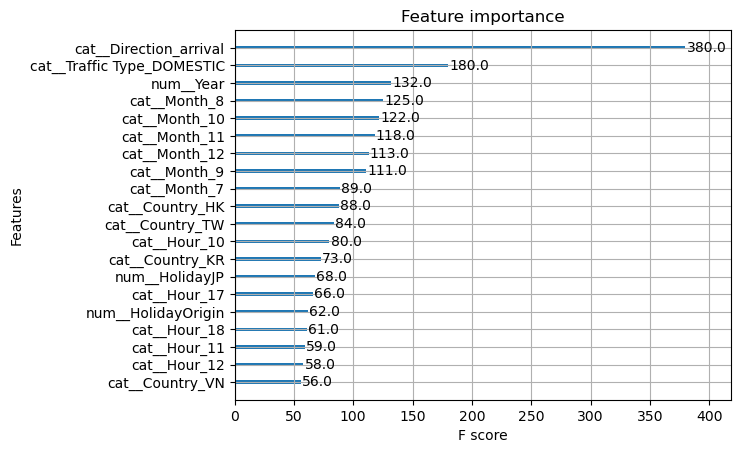

In [40]:
regressor["regressor"].get_booster().feature_names = list(
    regressor["preprocessor"].get_feature_names_out()
)
xgb.plot_importance(regressor["regressor"], ax=plt.gca(), max_num_features=20)

# Test model on future schedule

In [41]:
# split dataset for X, y and train, test
X_forecast = data_forecast_clean.drop(
    [
        "Capacity",
        "L Board Pax",
        "Datetime",
        "UniqueID",
        "Flight Designator",
        "Load Factor",
    ],
    axis=1,
)
data_forecast_clean["Load Factor ML"] = regressor.predict(X_forecast)
data_forecast_clean["L Board Pax ML"] = (
    data_forecast_clean["Capacity"] * data_forecast_clean["Load Factor ML"]
)

# Weekday average over last 2 weeks method

In [42]:
class Asai_estimator:
    """
    An estimator to be trained on last 2 weeks of international flights.
    Estimate future flights LF based on the weekday average over last 2 weeks
    """

    def __init__(self) -> None:
        pass

    def train(self, X_train, y_train):
        """
        build a DataFrame of LF for international flights
        by direction, by weekday, takes the average of last 2 weeks of available data
        """
        X_train["Datetime"] = pd.to_datetime(
            X_train["Year"].astype(str)
            + "-"
            + X_train["Month"].astype(str)
            + "-"
            + X_train["Day"].astype(str)
        )
        X_train["LF"] = y_train
        train = X_train

        # select last 2 weeks of international flights
        mask_2weeks = (
            train["Datetime"] < train["Datetime"].max() - pd.Timedelta(days=1)
        ) & (train["Datetime"] > train["Datetime"].max() - pd.Timedelta(days=16))
        mask_int = train["Traffic Type"] == "INTERNATIONAL"

        self.LF_RefTable = train[mask_2weeks & mask_int].copy()

        # group by weekday and direction and take the average
        self.LF_RefTable = self.LF_RefTable.groupby(by=["Weekday", "Direction"])[
            ["LF"]
        ].agg("mean")

    def predict(self, X_forecast):
        result = X_forecast.join(self.LF_RefTable, on=["Weekday", "Direction"])
        self.prediction = result["LF"]
        return self.prediction

In [43]:
# predict and put values in dataframe
estimator = Asai_estimator()
estimator.train(X_train, y_train)

data_forecast_clean["Load Factor Asai"] = estimator.predict(X_forecast)
data_forecast_clean["L Board Pax Asai"] = (
    data_forecast_clean["Capacity"] * data_forecast_clean["Load Factor Asai"]
)

# quick plot for results

/tmp/ipykernel_1128/899258232.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=45, **{"horizontalalignment": "right"})


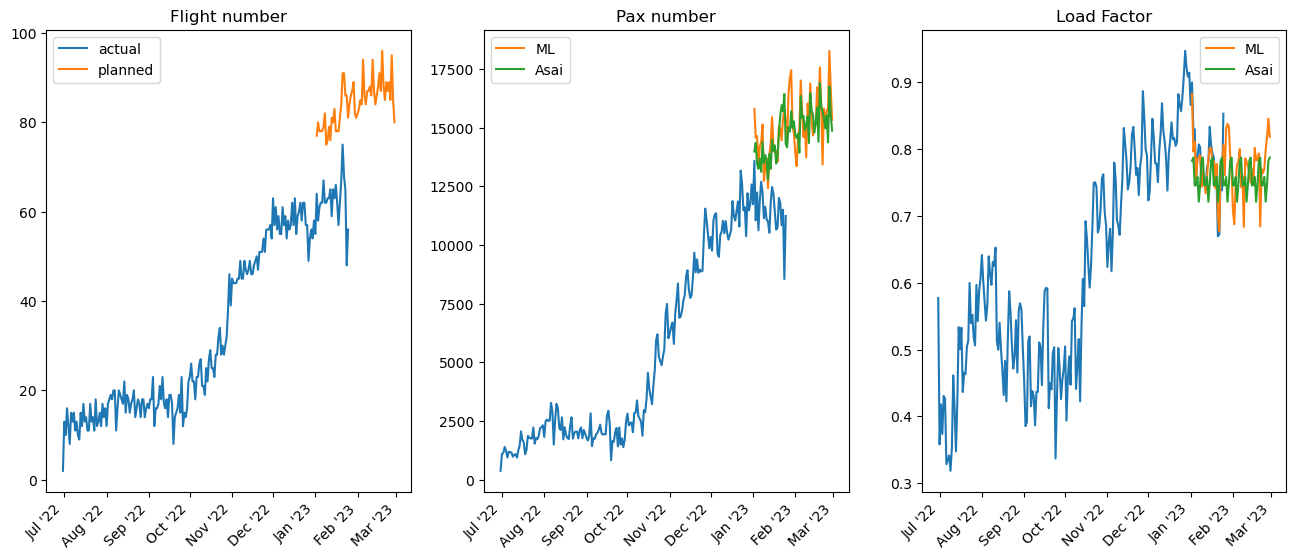

In [44]:
# prepare graphs for Pax count international departure

# actual
data_actual_result = data_actual_clean.set_index("Datetime", drop=True)
mask = (data_actual_result["Traffic Type"] == "INTERNATIONAL") & (
    data_actual_result["Direction"] == "departure"
)
plot_actual_pax = data_actual_result[mask]["L Board Pax"].groupby(
    pd.to_datetime(data_actual_result[mask].index).date
)

plot_actual_LF = data_actual_result[mask]["Load Factor"].groupby(
    pd.to_datetime(data_actual_result[mask].index).date
)

# forecast
data_forecast_result = data_forecast_clean.set_index("Datetime", drop=True)

mask = (data_forecast_result["Traffic Type"] == "INTERNATIONAL") & (
    data_forecast_result["Direction"] == "departure"
)

plot_forecast_pax_ML = data_forecast_result[mask]["L Board Pax ML"].groupby(
    pd.to_datetime(data_forecast_result[mask].index).date
)
plot_forecast_LF_ML = data_forecast_result[mask]["Load Factor ML"].groupby(
    pd.to_datetime(data_forecast_result[mask].index).date
)

plot_forecast_pax_Asai = data_forecast_result[mask]["L Board Pax Asai"].groupby(
    pd.to_datetime(data_forecast_result[mask].index).date
)
plot_forecast_LF_Asai = data_forecast_result[mask]["Load Factor Asai"].groupby(
    pd.to_datetime(data_forecast_result[mask].index).date
)

fig, ax = plt.subplots(
    ncols=3,
    figsize=(16, 6),
)

ax[0].plot(plot_actual_pax.agg("count"), label="actual")
ax[0].plot(plot_forecast_pax_ML.agg("count"), label="planned")
ax[0].set(title="Flight number")

ax[1].plot(plot_actual_pax.agg("sum"))
ax[1].plot(plot_forecast_pax_ML.agg("sum"), label="ML")
ax[1].plot(plot_forecast_pax_Asai.agg("sum"), label="Asai")
ax[1].set(title="Pax number")

ax[2].plot(plot_actual_LF.agg("mean"))
ax[2].plot(plot_forecast_LF_ML.agg("mean"), label="ML")
ax[2].plot(plot_forecast_LF_Asai.agg("mean"), label="Asai")
ax[2].set(title="Load Factor")

myFmt = mdates.DateFormatter("%b '%y")
for ax in ax:
    ax.set_xticklabels(ax.get_xticks(), rotation=45, **{"horizontalalignment": "right"})
    ax.xaxis.set_major_formatter(myFmt)
    ax.legend()

# CSV output

In [45]:
result = pd.DataFrame.from_dict(
    {
        "uniqueID": [
            y for x in data_forecast_result["UniqueID"].to_list() for y in [x, x]
        ],
        "Datetime": [y for x in data_forecast_result.index.to_list() for y in [x, x]],
        "Model": ["ML", "Asai"] * len(data_forecast_result["UniqueID"]),
        "Load Factor": [
            x
            for sub in zip(
                data_forecast_result["Load Factor ML"].to_list(),
                data_forecast_result["Load Factor Asai"].to_list(),
            )
            for x in sub
        ],
        "Pax": [
            x
            for sub in zip(
                data_forecast_result["L Board Pax ML"].to_list(),
                data_forecast_result["L Board Pax Asai"].to_list(),
            )
            for x in sub
        ],
    }
)

In [46]:
result

,uniqueID,Datetime,Model,Load Factor,Pax
0,2023/01/03 MU 7730,2023-01-03 16:00:00,ML,0.663311,0.000000
1,2023/01/03 MU 7730,2023-01-03 16:00:00,Asai,0.787354,0.000000
2,2023/01/04 MU 7730,2023-01-04 16:00:00,ML,0.619225,0.000000
3,2023/01/04 MU 7730,2023-01-04 16:00:00,Asai,0.745462,0.000000
4,2023/01/05 MU 7730,2023-01-05 16:00:00,ML,0.531509,0.000000
...,...,...,...,...,...
36701,2023/01/31 CX 502,2023-01-31 21:05:00,Asai,0.827094,231.586392
36702,2023/01/31 BK 3195,2023-01-31 23:00:00,ML,0.604835,95.563898
36703,2023/01/31 BK 3195,2023-01-31 23:00:00,Asai,0.827094,130.680893
36704,2023/01/31 BK 3197,2023-01-31 23:00:00,ML,0.604835,95.563898


In [47]:
out_path = Path("/home/antoine/projects/forecasting/output") / "forecast_new.csv"
result.to_csv(out_path)

OSError: Cannot save file into a non-existent directory: '/home/antoine/projects/forecasting/output'

In [ ]:
# extract 15 Feb~
test = pd.read_csv("/home/antoine/projects/forecasting/output/forecast_new.csv")
mask = pd.to_datetime(test["Datetime"]) > pd.to_datetime("2023-02-15")
out_path = (
    Path("/home/antoine/projects/forecasting/output") / "forecast_new_after1502.csv"
)
test[mask].to_csv(out_path)

In [ ]:
test = pd.read_csv("/home/antoine/projects/forecasting/output/forecast_jan.csv")
mask = pd.to_datetime(test["Datetime"]).dt.month == 1
out_path = Path("/home/antoine/projects/forecasting/output") / "forecast_jan_edit.csv"
test[mask].to_csv(out_path)

test = pd.read_csv("/home/antoine/projects/forecasting/output/forecast_feb.csv")
mask = pd.to_datetime(test["Datetime"]).dt.month == 2
out_path = Path("/home/antoine/projects/forecasting/output") / "forecast_feb_edit.csv"
test[mask].to_csv(out_path)